# Traffic Light Controller for a Single 4-Way Road Intersection using Soft Actor Critic algorithm

## Installations

We use SUMO (Simulation of Urban MObility) for simulating the traffic environment

In [1]:
!sudo apt-get install -y sumo sumo-tools sumo-doc
!pip install sumolib traci
!pip install torchviz
!pip install stable-baselines3 gym




The following additional packages will be installed:
  binfmt-support fastjar fonts-roboto-unhinted gdal-data jarwrapper
  javascript-common libarmadillo9 libarpack2 libcfitsio8 libcharls2 libdap25
  libdapclient6v5 libepsilon1 libfox-1.6-0 libfreexl1 libfyba0 libgdal26
  libgeos-3.8.0 libgeos-c1v5 libgeotiff5 libglu1-mesa libhdf4-0-alt
  libjs-jquery libjs-openlayers libjs-underscore libkmlbase1 libkmldom1
  libkmlengine1 libminizip1 libmysqlclient21 libnetcdf15 libodbc1 libogdi4.1
  libpoppler97 libpq5 libproj15 libqhull7 libspatialite7 libsuperlu5
  liburiparser1 libxerces-c3.2 mysql-common odbcinst odbcinst1debian2
  poppler-data proj-bin proj-data
Suggested packages:
  apache2 | lighttpd | httpd geotiff-bin gdal-bin libgeotiff-epsg libhdf4-doc
  libhdf4-alt-dev hdf4-tools libmyodbc odbc-postgresql tdsodbc unixodbc-bin
  ogdi-bin poppler-utils ghostscript fonts-japanese-mincho
  | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  fonts-arphic-ukai fonts-arphic-

In [2]:
!whereis sumo-gui

sumo-gui: /usr/bin/sumo-gui


In [3]:
# Confirming presence of sumocfg file
!ls /usr/share/sumo/tools/game/cross_demo.sumocfg

/usr/share/sumo/tools/game/cross_demo.sumocfg


In [4]:
# Confirming presence of the network file for cross_demo.sumocfg
!ls /usr/share/sumo/tools/game/cross/cross.net.xml

/usr/share/sumo/tools/game/cross/cross.net.xml


## Imports

In [5]:
import traci
import sumolib
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchviz import make_dot

import gymnasium as gym
from stable_baselines3 import SAC
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback
from gymnasium.spaces import Box, Dict, Discrete

2024-05-01 12:26:15.477920: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 12:26:15.478017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 12:26:15.609746: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Utility functions

In [6]:
# Get the appropriate device (CUDA or CPU)
def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def dict_to_sorted_numpy_array(dictionary):
    # Sort the keys
    sorted_keys = sorted(dictionary.keys())
    # Create a list of values in sorted order
    sorted_values = [dictionary[key] for key in sorted_keys]
    # Convert to numpy array
    np_array = np.array(sorted_values, dtype=np.float32)
    return np_array

## Creating a custom gym environment

In [7]:
class SingleRoadIntersectionEnv(gym.Env):
    
    def __init__(self):
        
        self.max_episode_steps = 5000
        
        self.AREA_SIZE = self.get_frame_dimensions()
        
        self.GRID_SIZE = (int(self.AREA_SIZE[0]), int(self.AREA_SIZE[1]))  # Rows and columns in the grid 
        self.GRID_RES = (self.AREA_SIZE[0] /self.GRID_SIZE[0], self.AREA_SIZE[1] / self.GRID_SIZE[1])   
        
        # Path to SUMO binary
        self.sumoBinary = "/usr/bin/sumo"
        self.sumoCmd = [self.sumoBinary, "-c", "/usr/share/sumo/tools/game/cross_demo.sumocfg"]
        
        # Start the SUMO simulation
        traci.start(self.sumoCmd)
        
        lanes = traci.lane.getIDList()
        
        # Define the observation space using gym.spaces.Dict
        self.observation_space = Dict({
            "queue_length": Box(low=0, high=np.inf, shape=(len(lanes),), dtype=np.float32),
            "vehicle_count": Box(low=0, high=np.inf, shape=(len(lanes),), dtype=np.float32),
            "avg_waiting_time": Box(low=0, high=np.inf, shape=(len(lanes),), dtype=np.float32),
            "current_phase": Box(low=0, high=11, shape=(1,), dtype=np.float32),
            "next_phase": Box(low=0, high=11, shape=(1,), dtype=np.float32),
            "vehicle_grid": Box(low=0, high=1, shape=(int(self.AREA_SIZE[0]), int(self.AREA_SIZE[1])), dtype=np.float32),
        })

        # Define continuous action space
        self.action_space = Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        
        # Setting the initial state
        self.state = self.get_current_state()
        
        # Keeping track of the simulation time at phase changes
        self.simulation_time_at_phase_change = traci.simulation.getCurrentTime()/1000
        
        # Initialising episode_steps and cumulative_reward
        self.episode_steps = 0
        self.cumulative_reward = 0
        
        self.reward_factors = None

    def reset(self, seed=None):
        # End SUMO simulation
        traci.close()
        # Start the SUMO simulation
        traci.start(self.sumoCmd)
        # Keeping track of the simulation time at phase changes
        self.simulation_time_at_phase_change = traci.simulation.getCurrentTime()/1000
        # Initialising episode_steps and cumulative_reward
        self.episode_steps = 0
        self.cumulative_reward = 0
        
        self.state = self.get_current_state() # Get the initial state
        return (self.state, {})  # Return the initial state

    def step(self, action):
#         print("ACTION:", action)
        # Get the current state
        current_state = self.state

        # Dictionary to store vehicle entry times
        vehicle_start_times = {}

        # Get current simulation time (in seconds)
        current_time = traci.simulation.getCurrentTime() / 1000  # Convert from ms to s

        # Compute vehicle start times
        vehicle_ids = traci.vehicle.getIDList()
        for veh_id in vehicle_ids:
            # Update the start time (to be tracked from last action taken)
            vehicle_start_times[veh_id] = current_time
            
            
            
        traffic_light_ids = traci.trafficlight.getIDList()
        # Determine the next action (continuous) to manage traffic lights
        if action[0] > 0:
            action = 1
        else:
            action = 0
            
#         print("\n\nACTION TAKEN = "+str(action)+"\n\n")
        
        # Advance simulation by one step
        traci.simulationStep()

        # Set traffic light phase according to action chosen
        if action == 1:
            traci.trafficlight.setPhase(traffic_light_ids[0], (current_state["current_phase"][0] + 1) % 12)
        else:
            traci.trafficlight.setPhase(traffic_light_ids[0], current_state["current_phase"][0])
            
            
        
        # Get the new state after action is taken
        next_state = self.get_current_state()
        
        

        # Get current simulation time (in seconds)
        current_time = traci.simulation.getCurrentTime() / 1000  # Convert from ms to s

        # List to store travel times for vehicles that have exited the frame
        vehicle_travel_times = []

        # Track vehicles that have exited
        arrived_vehicle_ids = traci.simulation.getArrivedIDList()
        for veh_id in arrived_vehicle_ids:
            if veh_id in vehicle_start_times:
                # Calculate travel time
                start_time = vehicle_start_times[veh_id]
                travel_time = current_time - start_time

                # Store the travel time
                vehicle_travel_times.append(travel_time)

                # Remove the vehicle from the tracking dictionary
                del vehicle_start_times[veh_id]
                
                
                
        # Get the reward
        reward, reward_factors = self.getReward(current_state, next_state, vehicle_travel_times)
        self.reward_factors = reward_factors
        
        
        
        # Update simulation_time_at_phase_change if a phase change has occured
        traffic_light_changes = sum(
            1 if next_state["current_phase"][0] != current_state["current_phase"][0] else 0
            for tl in traci.trafficlight.getIDList()
        )
        phase_change = 0
        if traffic_light_changes > 0:
            phase_change = 1
        if phase_change == 1:
            self.simulation_time_at_phase_change = traci.simulation.getCurrentTime()/1000
            
            
             
        # Calculate cumulative reward, append data to replay buffer etc...
        self.cumulative_reward += reward
                    
        info = {}  # Additional information if needed

        self.state = next_state  # Update the state
        
        self.episode_steps += 1
        
        # Determine whether the episode is done
        done = False
        if self.episode_steps == self.max_episode_steps:
            done = True
        if done:                   
            print("Cumulative Reward: "+str(self.cumulative_reward))

        return next_state, reward, done, False, info
        #obs, reward, terminated, truncated, info

    def close(self):
        # End SUMO simulation
        traci.close()
        # Resetting episode_steps and cumulative_reward
        self.episode_steps = 0
        self.cumulative_reward = 0
        
    def get_frame_dimensions(self):
        # Load the network file
        net_file = "/usr/share/sumo/tools/game/cross/cross.net.xml"
        net = sumolib.net.readNet(net_file)

        # Get the network's boundaries
        bounding_box = net.getBoundary()

        # Calculate the width and height of the area
        width = bounding_box[2] - bounding_box[0]
        height = bounding_box[3] - bounding_box[1]

        AREA_SIZE = (width, height)  # Width and height of the area in meters

        return AREA_SIZE
    
    def get_next_phase(self, current_phase): # Note: This is specific to cross_demo.sumocfg 
        next_phase = {}
        for key in current_phase.keys():
            next_phase[key] = (current_phase[key] + 1)%12
        return next_phase
    
    # Define a function to extract the current state from the simulation
    def get_current_state(self):
        lanes = traci.lane.getIDList()
        queue_length = {lane: traci.lane.getLastStepHaltingNumber(lane) for lane in lanes}
        vehicle_count = {lane: traci.lane.getLastStepVehicleNumber(lane) for lane in lanes}
        avg_waiting_time = {lane: traci.lane.getWaitingTime(lane) for lane in lanes}
        traffic_light_ids = traci.trafficlight.getIDList()
        current_phase = {tl: traci.trafficlight.getPhase(tl) for tl in traffic_light_ids}
        next_phase = self.get_next_phase(current_phase)

        # Initialize the grid with zeros
        vehicle_grid = np.zeros((self.GRID_SIZE[1], self.GRID_SIZE[0]), dtype=np.float32)

        # Get all vehicle IDs
        vehicle_ids = traci.vehicle.getIDList()

        # Loop through all vehicles and place them on the grid
        for veh_id in vehicle_ids:
            # Get the position of the vehicle
            x, y = traci.vehicle.getPosition(veh_id)

            # Map the position to the grid indices
            row = int(y // self.GRID_RES[1])  # Rows are indexed by the y-coordinate
            col = int(x // self.GRID_RES[0])  # Columns are indexed by the x-coordinate

            # Ensure the indices are within the grid bounds
            if 0 <= row < self.GRID_SIZE[1] and 0 <= col < self.GRID_SIZE[0]:
                vehicle_grid[row, col] += 1  # Increment the count at the grid position
        
        return {
            "queue_length": dict_to_sorted_numpy_array(queue_length),
            "vehicle_count": dict_to_sorted_numpy_array(vehicle_count),
            "avg_waiting_time": dict_to_sorted_numpy_array(avg_waiting_time),
            "current_phase": dict_to_sorted_numpy_array(current_phase),
            "next_phase": dict_to_sorted_numpy_array(next_phase),
            "vehicle_grid": vehicle_grid,
        }
    
    # Function to compute the reward
    def getReward(self, previous_state, current_state, vehicle_travel_times):
        # Weights for each component of the reward
        WEIGHT_QUEUE_LENGTH = -0.7/1000
        WEIGHT_WAITING_TIME = -0.2/1000
        WEIGHT_PHASE_CHANGE = -1.0/1000
        WEIGHT_DELAY = -0.3/1000
        WEIGHT_VEHICLES_PASSED = 7.0/1000
        WEIGHT_ENVIRONMENTAL_COST = -0.4/1000
        WEIGHT_SUDDEN_PHASE_CHANGE = -25.0/1000
        WEIGHT_COLLISION = -15.0/1000
        WEIGHT_TRAVEL_TIME = -1.0/1000

        lanes = traci.lane.getIDList()

        # Sum of queue lengths (halting vehicles)
        queue_length = sum(traci.lane.getLastStepHaltingNumber(lane) for lane in lanes)

        # Sum of average waiting times
        avg_waiting_time = sum(traci.lane.getWaitingTime(lane) for lane in lanes)

        # Check if phase change has occured since the last step
        traffic_light_changes = sum(
            1 if current_state["current_phase"][0] != previous_state["current_phase"][0] else 0
            for tl in traci.trafficlight.getIDList()
        )
        phase_change = 0
        if traffic_light_changes > 0:
            phase_change = 1

        # Calculate delay for all vehicles
        total_delay = sum(
            (1 - (traci.vehicle.getSpeed(veh) / traci.vehicle.getAllowedSpeed(veh))) for veh in traci.vehicle.getIDList()
        )

        # Number of vehicles which arrived (have reached their destination and are removed from the road network) in this time step
        vehicles_passed = traci.simulation.getArrivedNumber()

        # Environmental cost (based on CO2 and CO emissions)
        total_emissions = sum(traci.vehicle.getCO2Emission(veh) for veh in traci.vehicle.getIDList()) + sum(traci.vehicle.getCOEmission(veh) for veh in traci.vehicle.getIDList())
        total_emissions = total_emissions/1000

        # Penalty for sudden changes (if the phase duration was too short)
        min_phase_duration = 5  # penalize if phases switch within 5 seconds
        sudden_traffic_light_changes = sum(
            1 if ((phase_change == 1) and ((traci.simulation.getCurrentTime()/1000 - self.simulation_time_at_phase_change) < min_phase_duration) and ((current_state["current_phase"][0] % 3) == 0)) else 0
            for tl in traci.trafficlight.getIDList()
        )
        sudden_phase_change = 0
        if sudden_traffic_light_changes > 0:
            sudden_phase_change = 1

        # Penalty for collision between vehicles
        num_collided_vehicles = traci.simulation.getCollidingVehiclesNumber()

        # Penalty for a high value of average travel time for vehicles which exited the frame
        average_travel_time = 0
        if len(vehicle_travel_times) != 0:
            average_travel_time = np.mean(vehicle_travel_times)

        # Compute the reward as a weighted sum of factors
        reward = (
            (WEIGHT_QUEUE_LENGTH * queue_length) +
            (WEIGHT_WAITING_TIME * avg_waiting_time) +
            (WEIGHT_PHASE_CHANGE * phase_change) +
            (WEIGHT_DELAY * total_delay) +
            (WEIGHT_VEHICLES_PASSED * vehicles_passed) +
            (WEIGHT_ENVIRONMENTAL_COST * total_emissions) +
            (WEIGHT_SUDDEN_PHASE_CHANGE * sudden_phase_change) +
            (WEIGHT_COLLISION * num_collided_vehicles) + 
            (WEIGHT_TRAVEL_TIME * average_travel_time)
        )

        # Preparing the reward factors as well
        reward_factors = {}
        reward_factors["queue_length"] = queue_length     # Number
        reward_factors["avg_waiting_time"] = avg_waiting_time     # Seconds 
        reward_factors["phase_change"] = phase_change     # Flag
        reward_factors["total_delay"] = total_delay     # Sum of fractions
        reward_factors["vehicles_passed"] = vehicles_passed     # Number
        reward_factors["total_emissions"] = total_emissions     # grams/second
        reward_factors["sudden_phase_change"] = sudden_phase_change     # Flag
        reward_factors["num_collided_vehicles"] = num_collided_vehicles     # Number
        reward_factors["average_travel_time"] = average_travel_time     # Second 

        return reward, reward_factors


## Training

In [8]:
# Create the environment
env = SingleRoadIntersectionEnv()
check_env(env)  # Ensure compatibility with Gym

# Instantiate the SAC agent
sac_model = SAC("MultiInputPolicy", env, verbose=1, buffer_size = 8000)

# Train the SAC agent with validation callback
sac_model.learn(total_timesteps=50000)

# Save the model
sac_model.save("SACModel")

# Close the environment
env.close()

 Retrying in 1 seconds
Loading configuration ... done.


/tmp/ipykernel_24/2116822760.py:38: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  self.simulation_time_at_phase_change = traci.simulation.getCurrentTime()/1000


 Retrying in 1 seconds
Loading configuration ... done.


/tmp/ipykernel_24/2116822760.py:52: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  self.simulation_time_at_phase_change = traci.simulation.getCurrentTime()/1000
/opt/conda/lib/python3.10/site-packages/stable_baselines3/common/env_checker.py:244: UserWarning: Your observation vehicle_grid has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


 Retrying in 1 seconds
Loading configuration ... done.


/tmp/ipykernel_24/2116822760.py:69: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  current_time = traci.simulation.getCurrentTime() / 1000  # Convert from ms to s
/tmp/ipykernel_24/2116822760.py:105: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  current_time = traci.simulation.getCurrentTime() / 1000  # Convert from ms to s
/tmp/ipykernel_24/2116822760.py:276: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  1 if ((phase_change == 1) and ((traci.simulation.getCurrentTime()/1000 - self.simulation_time_at_phase_change) < min_phase_duration) and ((current_state["current_phase"][0] % 3) == 0)) else 0
/tmp/ipykernel_24/2116822760.py:141: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  self.simulation_time_at_phase_change = traci.simulation.getCurrentTime()/1000


 Retrying in 1 seconds
Loading configuration ... done.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
 Retrying in 1 seconds
Loading configuration ... done.


/tmp/ipykernel_24/2116822760.py:52: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  self.simulation_time_at_phase_change = traci.simulation.getCurrentTime()/1000
/tmp/ipykernel_24/2116822760.py:69: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  current_time = traci.simulation.getCurrentTime() / 1000  # Convert from ms to s
/tmp/ipykernel_24/2116822760.py:105: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  current_time = traci.simulation.getCurrentTime() / 1000  # Convert from ms to s
/tmp/ipykernel_24/2116822760.py:276: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  1 if ((phase_change == 1) and ((traci.simulation.getCurrentTime()/1000 - self.simulation_time_at_phase_change) < min_phase_duration) and ((current_state["current_phase"][0] % 3) == 0)) else 0
/tmp/ipykernel_24/21

S

Step #71.20

Step #79.40

Step #103.20

Step #104.00

Step #123.60

Step #124.60

Step #152.60

Step #163.40

Step #163.80

Step #165.60

Step #191.60

Step #192.60

Step #194.20

Step #213.00

Step #213.20

Step #271.20

Step #289.80

Step #343.00

Step #343.80

Step #346.60

Step #391.00

Step #431.20

Step #432.00

Step #438.00

Step #485.20

Step #500.00

Step #508.20

Step #554.80

Step #555.60

Step #561.60

Step #562.00

Step #572.60

Step #573.20

Step #669.60

Step #669.80

Step #674.20

Step #810.00

Step #822.60

Step #823.20

Step #844.40

Step #844.80

Step #853.80 

Step #860.80

Step #907.20

Step #915.40

Step #915.60

Step #947.80

Step #970.80

Step #971.00

Step #984.20

Step #993.20 Cumulative Reward: -421.50955698285844
 Retrying in 1 seconds
Loading configuration ... done.


Step

Step #67.60

Step #71.60

Step #72.20

Step #73.00

Step #78.40

Step #123.00

Step #123.40

Step #162.60

Step #211.00

Step #213.00

Step #213.40

Step #235.60

Step #239.60

Step #289.00

Step #289.20

Step #298.40

Step #299.20

Step #345.80

Step #346.00

Step #381.40

Step #386.40

Step #386.60

Step #392.40

Step #428.40 (0m

Step #452.00

Step #453.00

Step #500.00

Step #530.80

Step #531.20

Step #551.40

Step #565.80

Step #566.00

Step #582.40

Step #589.80

Step #615.00

Step #615.80

Step #618.40

Step #641.20

Step #645.00

Step #646.80

Step #664.80 (

Step #701.40

Step #748.20

Step #762.60

Step #762.80

Step #793.20

Step #793.40

Step #810.00

Step #815.60

Step #836.40

Step #873.60

Step #873.80

Step #880.00

Step #911.60

Step #917.60

Step #941.00

Step #945.80

Step #975.00

Step #993.00 (Cumulative Reward: -527.3959950575571
 Retrying in 1 seconds
Loading configuration ... done.


Step #131.40

Step #135.40

Step #257.80

Step #258.40

Step #277.20

Step #294.80

Step #302.80

Step #303.80

Step #308.40

Step #335.60 (1

Step #343.40

Step #370.80

Step #372.00

Step #385.20

Step #385.40

Step #386.00

Step #387.20

Step #482.60

Step #492.40

Step #493.00

Step #500.00

Step #523.20

Step #523.40

Step #523.80

Step #552.00

Step #552.20

Step #553.00

Step #612.00

Step #640.60

Step #646.60

Step #647.20

Step #767.80

Step #776.60

Step #777.40

Step #810.00

Step #841.40

Step #865.20

Step #867.00

Step #876.80

Step #912.80 (1m

Step #918.60

Step #926.40

Step #929.40

Step #944.20

Step #944.40

Step #946.00

Step #946.20

Step #950.20

Step #951.40

Step #951.60

Step #975.00

Step #993.00 (Cumulative Reward: -833.104732278844
 Retrying in 1 seconds
Loading configuration ... done.


Step #32.00

Step #32.80

Step #45.20

Step #45.40

Step #52.20

Step #75.40

Step #123.80

Step #124.60

Step #151.60 (0

Step #153.20

Step #162.40

Step #166.00

Step #169.20

Step #169.40

Step #193.20

Step #193.40

Step #223.20

Step #223.60

Step #237.80

Step #238.00

Step #301.00 (1ms ~

Step #310.60

Step #311.40

Step #312.20

Step #342.00

Step #384.20

Step #392.40

Step #392.80

Step #396.80

Step #401.20

Step #407.40

Step #407.80

Step #427.40

Step #427.60

Step #431.20

Step #452.60

Step #452.80

Step #455.00

Step #463.60

Step #463.80

Step #493.40

Step #500.00

Step #509.00

Step #584.00

Step #597.60

Step #606.60 

Step #632.00

Step #663.80

Step #771.40

Step #771.60

Step #772.00

Step #778.00

Step #778.20

Step #810.00

Step #854.00

Step #933.20

Step #975.00

Step #993.00 (Cumulative Reward: -779.4889872563546
 Retrying in 1 seconds
Loading configuration ... done.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5e+03    |
|    ep_rew_mean     | -640     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 3        |
|    time_elapsed    | 6527     |
|    total_timesteps | 20000    |
| train/             |          |
|    actor_loss      | -1.88    |
|    critic_loss     | 0.833    |
|    ent_coef        | 0.00541  |
|    ent_coef_loss   | -0.277   |
|    learning_rate   | 0.0003   |
|    n_updates       | 19899    |
---------------------------------


Step #32.00

Step #35.00

Step #35.20

Step #43.40

Step #53.40

Step #53.80

Step #60.20

Step #63.60

Step #76.00

Step #77.00

Step #104.20

Step #122.60

Step #129.20

Step #129.40

Step #145.40

Step #147.80

Step #165.80

Step #166.40

Step #168.40

Step #168.60

Step #273.00

Step #306.20

Step #330.80

Step #359.60

Step #382.20

Step #382.60

Step #405.80

Step #406.20

Step #449.20

Step #453.40

Step #498.40 (0ms

Step #514.20

Step #544.40

Step #553.00

Step #553.40

Step #618.40

Step #642.20

Step #656.40

Step #657.00

Step #666.40

Step #666.60

Step #706.60

Step #715.20

Step #719.40

Step #728.20

Step #728.40

Step #775.40

Step #775.60

Step #810.00

Step #841.80

Step #866.00

Step #963.20

Step #975.00

Step #986.40

Step #995.40 Cumulative Reward: -756.4741778194774
 Retrying in 1 seconds
Loading configuration ... done.


Step #12.00

Step #12.60

Step #30.60 (

Step #33.40

Step #42.00

Step #51.00 

Step #53.80

Step #62.40

Step #67.80

Step #72.00

Step #76.80

Step #77.40

Step #118.40

Step #122.20

Step #123.60

Step #124.80

Step #125.00

Step #141.80

Step #151.60

Step #163.40

Step #166.60

Step #169.00

Step #169.20

Step #192.00

Step #212.40

Step #223.40

Step #253.40

Step #258.20

Step #273.20

Step #288.80

Step #289.00

Step #302.20

Step #311.20 

Step #342.40

Step #359.00

Step #359.20

Step #360.20

Step #360.80

Step #500.00

Step #527.80

Step #529.00

Step #532.60

Step #532.80

Step #539.20

Step #557.40

Step #557.60

Step #562.60

Step #565.80

Step #773.40

Step #774.00

Step #805.40

Step #805.60

Step #810.00

Step #828.40

Step #901.40

Step #901.60

Step #910.80

Step #911.00

Step #931.20

Step #975.00

Step #993.00 (Cumulative Reward: -1083.6447754939265
 Retrying in 1 seconds
Loading configuration ... done.


Ste

Step #77.60

Step #95.60 (

Step #108.20

Step #123.60

Step #124.00

Step #132.40

Step #132.60

Step #165.60

Step #211.80

Step #222.20

Step #252.80

Step #253.40

Step #258.00

Step #300.40

Step #300.60

Step #301.00

Step #340.80

Step #341.20

Step #341.60

Step #341.80

Step #346.00

Step #370.20

Step #371.80

Step #387.00

Step #395.60

Step #432.00 (1m

Step #436.80

Step #452.40

Step #500.00

Step #519.40

Step #560.40

Step #562.80

Step #573.60

Step #574.00

Step #575.60

Step #634.20

Step #634.40

Step #643.00

Step #643.20

Step #682.20

Step #810.00

Step #814.00

Step #814.20

Step #820.60

Step #823.00

Step #823.20

Step #967.20 (1ms ~= 200.00*

Step #975.00

Step #975.40

Step #993.40 (Cumulative Reward: -904.6214970508943
 Retrying in 1 seconds
Loading configuration ... done.


Step #122.60

Step #123.80

Step #124.00

Step #125.00

Step #125.20

Step #152.60

Step #175.00

Step #177.40

Step #177.60

Step #194.60

Step #195.20

Step #211.60

Step #213.00

Step #226.80

Step #235.80

Step #236.00

Step #244.80

Step #245.20

Step #266.40

Step #273.20

Step #273.40

Step #288.40

Step #297.40 

Step #303.00

Step #352.60

Step #353.40

Step #353.80

Step #372.00

Step #390.00 (

Step #419.20

Step #455.20 (1m

Step #457.80

Step #463.20

Step #491.60

Step #500.00

Step #599.00

Step #599.40

Step #615.80

Step #632.60

Step #633.20

Step #672.40

Step #686.20

Step #686.80

Step #687.00

Step #705.80

Step #706.00

Step #719.60

Step #771.80

Step #804.00

Step #833.20

Step #880.80

Step #926.20

Step #945.20

Step #945.40

Step #959.20

Step #971.20

Step #974.00

Step #975.00

Step #995.00

Step #995.20

Cumulative Reward: -711.0732116643946
 Retrying in 1 seconds
Loading configuration ... done.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5e+03    |
|    ep_rew_mean     | -752     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 3        |
|    time_elapsed    | 13101    |
|    total_timesteps | 40000    |
| train/             |          |
|    actor_loss      | 14       |
|    critic_loss     | 0.0252   |
|    ent_coef        | 0.00475  |
|    ent_coef_loss   | -0.478   |
|    learning_rate   | 0.0003   |
|    n_updates       | 39899    |
---------------------------------


Ste

Step #73.40

Step #73.60

Step #76.80

Step #77.20

Step #122.40

Step #163.80

Step #166.40

Step #209.60

Step #209.80

Step #212.60

Step #221.40

Step #236.20

Step #257.40

Step #266.40 

Step #325.80 (0ms 

Step #329.80

Step #332.60

Step #344.80

Step #346.00

Step #348.40

Step #424.00

Step #424.60

Step #463.00

Step #500.00

Step #501.40

Step #530.60

Step #530.80

Step #588.20

Step #588.40

Step #604.40

Step #632.80

Step #673.40

Step #687.00

Step #687.20

Step #716.00

Step #718.00

Step #783.00

Step #810.00

Step #812.00

Step #812.80

Step #966.80

Step #967.00

Step #975.00

Step #993.20

Step #994.40

Step #994.80

Cumulative Reward: -1119.6497381841264
 Retrying in 1 seconds
Loading configuration ... done.


Step #13.00

Step #13.60

Step #41.00

Step #57.60

Step #58.00

Step #58.80

Step #73.40

Step #89.20

Step #89.40

Step #90.60

Step #99.60 

Step #104.20

Step #104.60

Step #122.80

Step #123.20

Step #125.20

Step #132.40

Step #132.60

Step #138.60

Step #138.80

Step #156.80 (

Step #169.00

Step #169.20

Step #192.00

Step #195.00

Step #211.00

Step #237.00

Step #257.20

Step #272.80

Step #273.20

Step #287.60

Step #300.80

Step #311.20

Step #331.00

Step #334.00

Step #334.20

Step #342.20

Step #345.20

Step #346.40

Step #349.40

Step #350.00

Step #377.20

Step #390.40

Step #392.80

Step #432.40 (0m

Step #436.00

Step #500.00

Step #502.20

Step #505.20

Step #508.20

Step #589.80

Step #594.00

Step #603.00 

Step #634.20

Step #676.40

Step #699.20

Step #699.40

Step #719.00

Step #723.80

Step #752.40

Step #773.60

Step #776.00

Step #778.40

Step #781.40

Step #810.00

Step #813.80

Step #814.20

Step #841.80

Step #843.60

Step #878.20

Step #886.00

Step #886.60

Step #920.20

Step #942.80

Step #943.40

Step #952.40

Step #975.00

Step #993.00 (Cumulative Reward: -667.6052895436886
 Retrying in 1 seconds
Loading configuration ... done.


## Evaluation

### Extracting the data for eval episodes

We are going to average all our metrics over the eval episodes

In [9]:
# Load the pre-trained SAC model
sac_model = SAC.load("SACModel")

env = SingleRoadIntersectionEnv()

num_eval_episodes = 5
eval_data = []

for episode in range(num_eval_episodes):
    eval_data.append([])
    state, info = env.reset()  # Reset the environment
    
    done = False
    while not done:
        # Predict the action using the SAC model
        action, _ = sac_model.predict(state, deterministic=True)  # Use deterministic for inference
        
        # Perform the action and get the new state
        next_state, reward, done, _, info = env.step(action) #obs, reward, terminated, truncated, info
        state = next_state
        
        reward_factors = env.reward_factors
        eval_data[-1].append((reward, reward_factors))
           
# Close the environment
env.close()

 Retrying in 1 seconds
Loading configuration ... done.


/tmp/ipykernel_24/2116822760.py:38: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  self.simulation_time_at_phase_change = traci.simulation.getCurrentTime()/1000


 Retrying in 1 seconds
Loading configuration ... done.


/tmp/ipykernel_24/2116822760.py:52: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  self.simulation_time_at_phase_change = traci.simulation.getCurrentTime()/1000
/tmp/ipykernel_24/2116822760.py:69: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  current_time = traci.simulation.getCurrentTime() / 1000  # Convert from ms to s
/tmp/ipykernel_24/2116822760.py:105: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  current_time = traci.simulation.getCurrentTime() / 1000  # Convert from ms to s
/tmp/ipykernel_24/2116822760.py:276: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  1 if ((phase_change == 1) and ((traci.simulation.getCurrentTime()/1000 - self.simulation_time_at_phase_change) < min_phase_duration) and ((current_state["current_phase"][0] % 3) == 0)) else 0
/tmp/ipykernel_24/21

S

Step #14.80

Step #31.20

Step #60.20

Step #71.20

Step #78.00

Step #92.60

Step #103.00

Step #123.40

Step #132.20

Step #148.00

Step #163.40

Step #174.20 

Step #193.60

Step #202.60 

Step #211.60

Step #230.80 (

Step #248.00

Step #271.00

Step #273.40

Step #282.40

Step #287.80

Step #301.60

Step #333.20

Step #345.00

Step #346.20

Step #370.20

Step #375.00

Step #391.20

Step #397.20

Step #430.20

Step #431.40

Step #433.80

Step #452.20

Step #462.60

Step #471.60 

Step #492.00

Step #500.00

Step #503.60

Step #548.60 (0ms

Step #586.40

Step #595.20

Step #613.40

Step #638.20

Step #667.80 (1

Step #672.80

Step #688.40

Step #715.20

Step #727.60

Step #795.20

Step #810.00

Step #819.80

Step #822.40

Step #825.20

Step #828.20

Step #830.00

Step #903.60

Step #921.20

Step #923.20

Step #949.20

Step #958.80

Step #975.00

Step #984.00 

Step #997.40 Cumulative Reward: -627.935637506321
 Retrying in 1 seconds
Loading configuration ... done.


Step #11.40

Step #31.20

Step #60.20

Step #71.20

Step #78.00

Step #92.60

Step #103.00

Step #121.60 (

Step #132.20

Step #148.00

Step #163.40

Step #165.20

Step #176.80

Step #193.60

Step #208.80

Step #212.80

Step #234.20

Step #248.00

Step #254.40

Step #271.00

Step #273.40

Step #282.40

Step #287.80

Step #296.80 

Step #333.20

Step #345.00

Step #346.20

Step #364.20 (

Step #375.00

Step #378.20

Step #391.20

Step #397.20

Step #430.20

Step #431.40

Step #433.80

Step #452.20

Step #462.60

Step #473.00

Step #491.00 (

Step #500.00

Step #503.60

Step #553.00

Step #586.40

Step #595.20

Step #613.40

Step #631.40 (

Step #640.80

Step #672.80

Step #674.00

Step #683.00 

Step #715.20

Step #727.60

Step #795.20

Step #810.00

Step #819.80

Step #825.20

Step #828.20

Step #903.60

Step #921.20

Step #922.80

Step #923.80

Step #949.20

Step #958.80

Step #975.00

Step #988.40

Step #997.40 Cumulative Reward: -627.935637506321
 Retrying in 1 seconds
Loading configuration ... done.


S

Step #14.80

Step #31.20

Step #60.20

Step #71.20

Step #78.00

Step #92.60

Step #103.00

Step #123.40

Step #132.20

Step #148.00

Step #163.40

Step #165.20

Step #176.80

Step #193.60

Step #208.80

Step #211.60

Step #212.80

Step #234.20

Step #248.00

Step #254.40

Step #271.00

Step #273.40

Step #282.40

Step #287.80

Step #296.80 

Step #333.20

Step #345.00

Step #346.20

Step #370.20

Step #378.20

Step #391.20

Step #397.20

Step #403.00

Step #430.20

Step #431.40

Step #433.80

Step #452.20

Step #462.60

Step #473.00

Step #492.00

Step #500.00

Step #503.60

Step #553.00

Step #586.40

Step #595.20

Step #604.20 

Step #638.20

Step #640.80

Step #667.80 (1

Step #672.80

Step #683.00 

Step #715.20

Step #727.60

Step #795.20

Step #810.00

Step #819.80

Step #822.40

Step #825.20

Step #828.20

Step #830.00

Step #903.60

Step #921.20

Step #922.80

Step #949.20

Step #958.80

Step #975.00

Step #988.40

Step #997.40 Cumulative Reward: -627.935637506321
 Retrying in 1 seconds
Loading configuration ... done.


S

Step #14.80

Step #31.20

Step #60.20

Step #71.20

Step #78.00

Step #92.60

Step #103.00

Step #123.40

Step #132.20

Step #148.00

Step #163.40

Step #165.20

Step #176.80

Step #193.60

Step #208.80

Step #211.60

Step #212.80

Step #234.20

Step #248.00

Step #254.40

Step #271.00

Step #273.40

Step #282.40

Step #287.80

Step #296.80 

Step #333.20

Step #345.00

Step #346.20

Step #370.20

Step #375.00

Step #378.20

Step #391.20

Step #397.20

Step #403.00

Step #430.20

Step #431.40

Step #433.80

Step #452.20

Step #462.60

Step #473.00

Step #491.00 (

Step #492.00

Step #503.60

Step #553.00

Step #586.40

Step #595.20

Step #613.40

Step #638.20

Step #640.80

Step #672.80

Step #674.00

Step #688.40

Step #715.20

Step #727.60

Step #795.20

Step #810.00

Step #819.80

Step #822.40

Step #825.20

Step #828.20

Step #903.60

Step #921.20

Step #922.80

Step #941.80 (

Step #958.80

Step #975.00

Step #988.40

Step #997.40 Cumulative Reward: -627.935637506321
 Retrying in 1 seconds
Loading configuration ... done.


Step #11.40

Step #31.20

Step #60.20

Step #71.20

Step #78.00

Step #92.60

Step #103.60

Step #123.40

Step #132.20

Step #148.00

Step #163.40

Step #165.20

Step #176.80

Step #193.60

Step #208.80

Step #212.80

Step #234.20

Step #248.00

Step #254.40

Step #271.00

Step #273.40

Step #282.40

Step #287.80

Step #301.60

Step #333.20

Step #345.00

Step #346.20

Step #364.20 (

Step #375.00

Step #378.20

Step #387.20 

Step #397.20

Step #403.00

Step #430.20

Step #431.40

Step #433.80

Step #452.20

Step #462.60

Step #473.00

Step #492.00

Step #500.00

Step #503.60

Step #553.00

Step #586.40

Step #595.20

Step #604.20 

Step #638.20

Step #640.80

Step #672.80

Step #674.00

Step #683.00 

Step #715.20

Step #727.60

Step #795.20

Step #810.00

Step #819.80

Step #822.40

Step #825.20

Step #828.20

Step #830.00

Step #903.60

Step #921.20

Step #922.80

Step #923.80

Step #949.20

Step #958.80

Step #975.00

Step #988.40

Step #997.40 Cumulative Reward: -627.935637506321


### Visualising the evaluation data obtained 

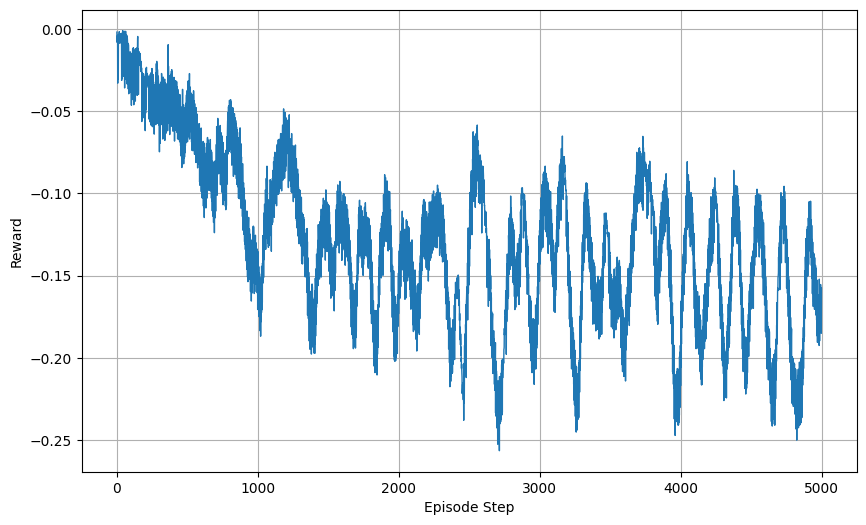

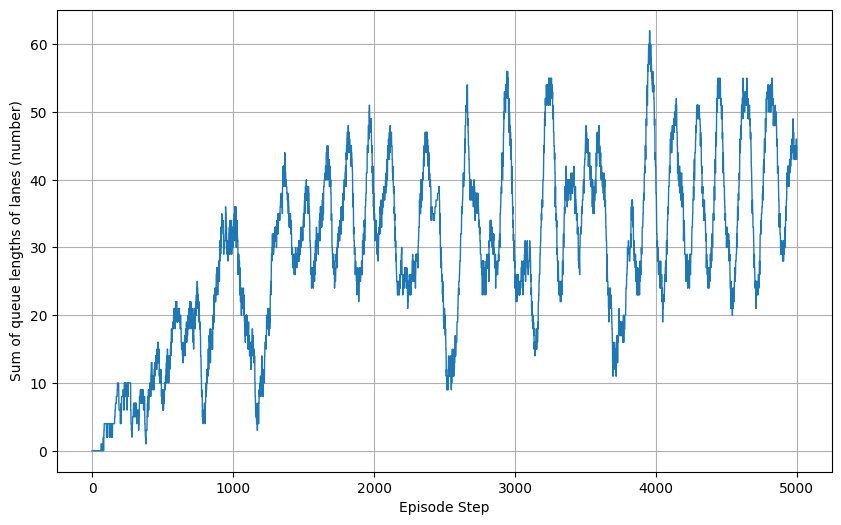

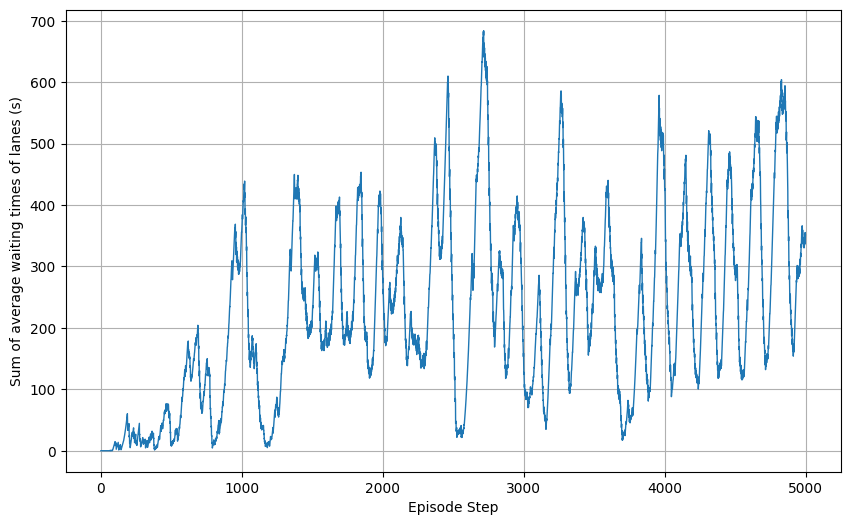

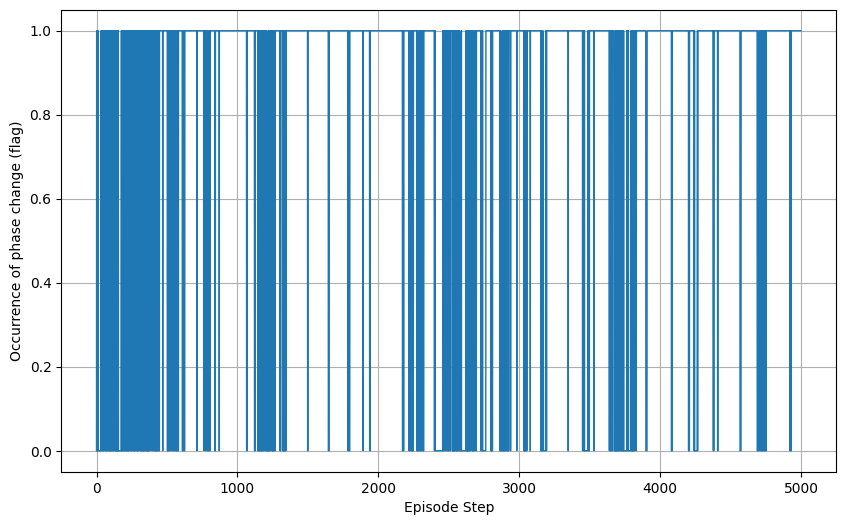

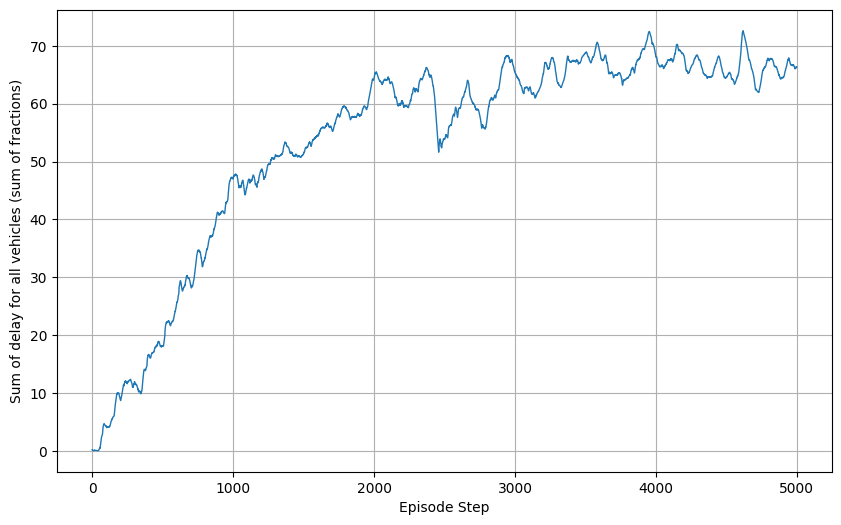

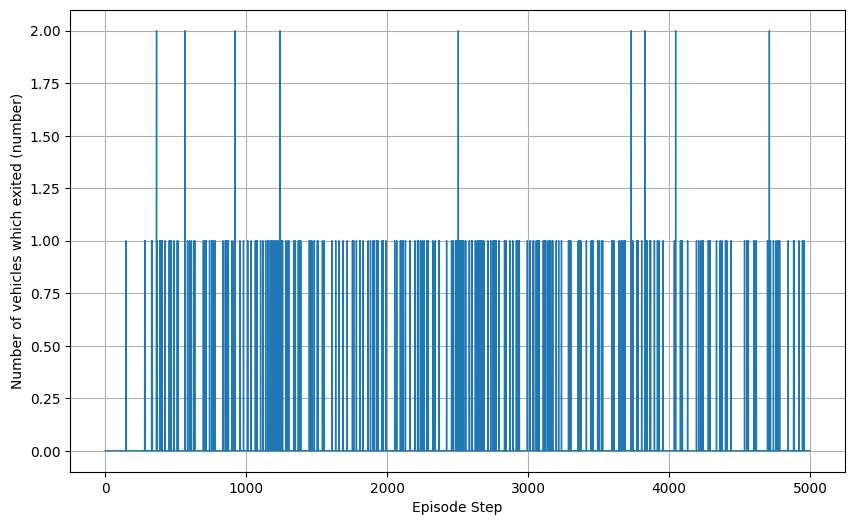

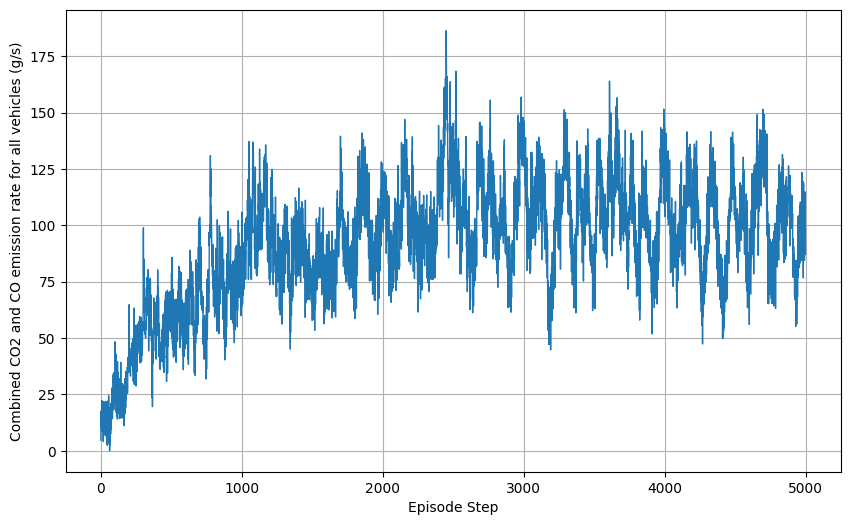

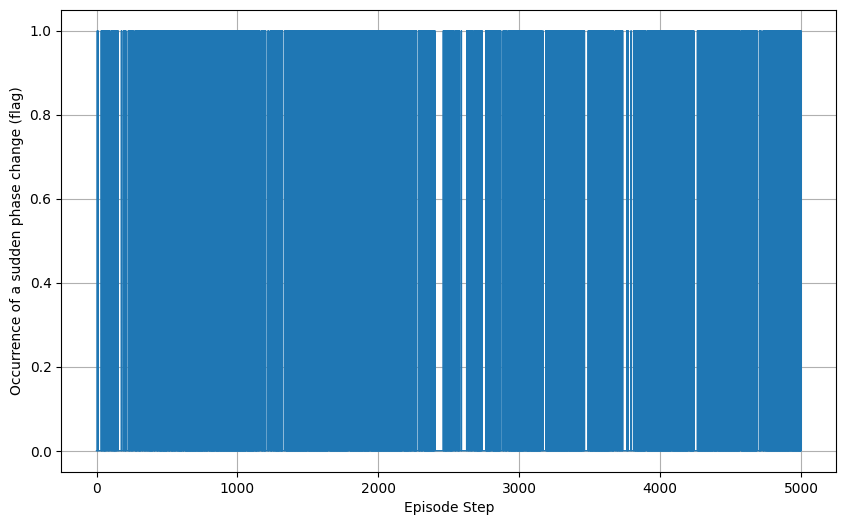

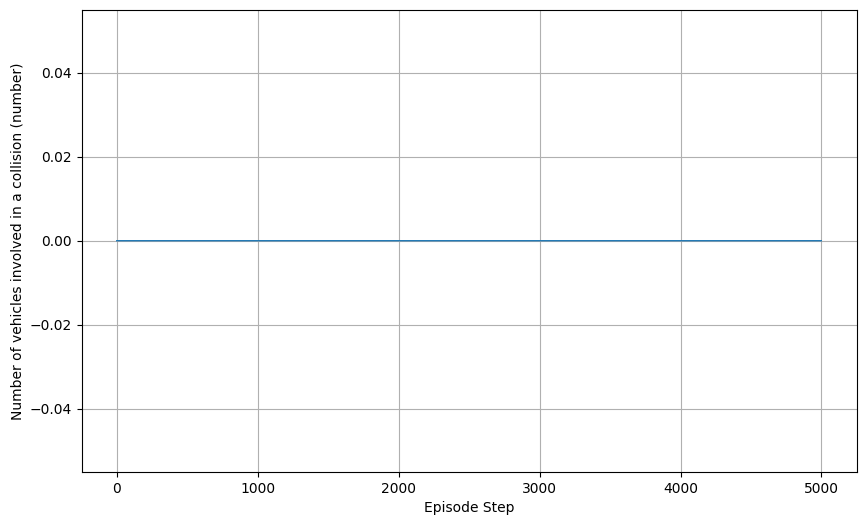

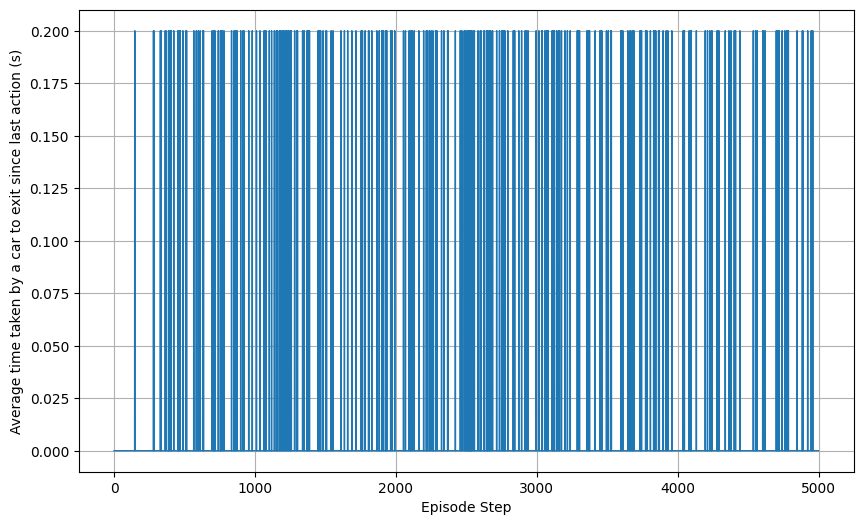

In [10]:
# Reward factor naming dictionary
naming_dict = {
    "queue_length": "Sum of queue lengths of lanes (number)",
    "avg_waiting_time": "Sum of average waiting times of lanes (s)",
    "phase_change": "Occurrence of phase change (flag)",
    "total_delay": "Sum of delay for all vehicles (sum of fractions)",
    "vehicles_passed": "Number of vehicles which exited (number)",
    "total_emissions": "Combined CO2 and CO emission rate for all vehicles (g/s)",
    "sudden_phase_change": "Occurrence of a sudden phase change (flag)",
    "num_collided_vehicles": "Number of vehicles involved in a collision (number)",
    "average_travel_time": "Average time taken by a car to exit since last action (s)"
}

# Number of steps for each episode
num_steps = len(eval_data[0])

# Initialize lists to store summed values for each step
reward_sums = []
reward_factor_sums = {
    "queue_length": [],
    "avg_waiting_time": [],
    "phase_change": [],
    "total_delay": [],
    "vehicles_passed": [],
    "total_emissions": [],
    "sudden_phase_change": [],
    "num_collided_vehicles": [],
    "average_travel_time": []
}
for i in range(num_steps):
    reward_sums.append(0)
    for key in reward_factor_sums:
        reward_factor_sums[key].append(0)

# Accumulate rewards and reward factors for each step across all episodes
for episode in eval_data:
    for step_index, (reward, reward_factors) in enumerate(episode):
        reward_sums[step_index] += reward
        
        for key in reward_factor_sums:
            reward_factor_sums[key][step_index] += reward_factors[key]

# Number of episodes
num_episodes = len(eval_data)

# Calculate the average for each step
average_rewards = [reward_sums[i] / num_episodes for i in range(num_steps)]

average_reward_factors = {
    key: [reward_factor_sums[key][i] / num_episodes for i in range(num_steps)]
    for key in reward_factor_sums
}

# Plotting
steps = np.arange(num_steps)  # X-axis for plotting

line_thickness = 1

# Plot average reward
plt.figure(figsize=(10, 6))
plt.plot(steps, average_rewards, linestyle='-', linewidth=line_thickness)
plt.xlabel("Episode Step")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

# Plot reward factors
for key, values in average_reward_factors.items():
    plt.figure(figsize=(10, 6))
    plt.plot(steps, values, linestyle='-', linewidth=line_thickness)
    plt.xlabel("Episode Step")
    plt.ylabel(naming_dict[key])
    plt.grid(True)
    plt.show()

In [11]:
# Function to compute min, max, mean and sum
def compute_stats(values):
    min_value = min(values)
    max_value = max(values)
    mean_value = np.mean(values)
    cumulative_value = sum(values)
    return min_value, max_value, mean_value, cumulative_value

# Compute and print the stats for average rewards
reward_min, reward_max, reward_mean, reward_cumulative = compute_stats(average_rewards)
print("Reward - Min:", reward_min)
print("Reward - Max:", reward_max)
print("Reward - Mean:", reward_mean)
print("Reward - Cumulative:", reward_cumulative)
print("")

# Compute and print the stats for each reward factor
for key, values in average_reward_factors.items():
    factor_min, factor_max, factor_mean, factor_cumulative = compute_stats(values)
    print(f"{naming_dict[key]} - Min:", factor_min)
    print(f"{naming_dict[key]} - Max:", factor_max)
    print(f"{naming_dict[key]} - Mean:", factor_mean)
    print(f"{naming_dict[key]} - Cumulative:", factor_cumulative)
    print("")

Reward - Min: -0.25647899745557895
Reward - Max: -0.0011114057554975725
Reward - Mean: -0.12558712750126422
Reward - Cumulative: -627.935637506321

Sum of queue lengths of lanes (number) - Min: 0.0
Sum of queue lengths of lanes (number) - Max: 62.0
Sum of queue lengths of lanes (number) - Mean: 29.568
Sum of queue lengths of lanes (number) - Cumulative: 147840.0

Sum of average waiting times of lanes (s) - Min: 0.0
Sum of average waiting times of lanes (s) - Max: 683.8000000000001
Sum of average waiting times of lanes (s) - Mean: 224.69415999999995
Sum of average waiting times of lanes (s) - Cumulative: 1123470.8000000014

Occurrence of phase change (flag) - Min: 0.0
Occurrence of phase change (flag) - Max: 1.0
Occurrence of phase change (flag) - Mean: 0.8108
Occurrence of phase change (flag) - Cumulative: 4054.0

Sum of delay for all vehicles (sum of fractions) - Min: 0.030940502448194684
Sum of delay for all vehicles (sum of fractions) - Max: 72.59949360366173
Sum of delay for all ve